In [1]:
import numpy as np
np.random.seed(5)

import matplotlib.pyplot as plt

import pandas as pd
import datetime


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras

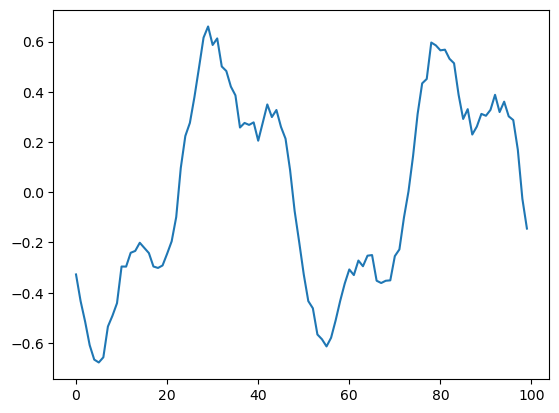

In [2]:
def generate_time_serie(n_steps):
    """Genera 4 números aleatorios

    Args:
        n_steps (int): El Nº De pasos

    Returns:
        serie: Una serie de Floats
    """
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, 1)
    time = np.linspace(0, 1, n_steps)
    serie = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    serie += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    serie += 0.1 * (np.random.rand(n_steps) - 0.5)   # + noise
    return serie.astype(np.float32)

n_steps = 100
s1 = generate_time_serie(n_steps)

# Utilizaremos esto como una serie para el modelo (Simulando que sea bolsa)
plt.plot(s1)

In [3]:
def genera_train(serie,lg_secuencia,lg_y):
    """Genera el set de entrenamiento

    Args:
        serie (pd.Serie): Serie de datos
        lg_secuencia (int): Longitud de la secuencia
        lg_y (int): Longitud de los datos recogidos
    """
    # Imaginemos que es de 20 entonces será 1000 - 20 - los valores que vamos recoger
    x=[]
    y=[]
    ultimo = len(serie)-lg_secuencia-lg_y
    for ix in range(ultimo):
      x.append(serie[ix:ix+lg_secuencia])
      y.append(serie[ix+lg_secuencia:ix+lg_secuencia+lg_y])
    return np.array(x), np.array(y)


# Generamos los train y test

In [4]:
lg_sec = 50
x, y = genera_train(s1, lg_sec, 1)
limite = int(len(x) * 0.8)
X_train, y_train = x[:limite], y[:limite]
X_test, y_test = x[limite:], y[limite:]


In [5]:
def plot_serie(serie, lg_sec, y, y_pred ):
  fig=plt.figure(figsize=(15,5))
  plt.plot(serie)
  plt.plot(lg_sec, y, "bo")
  plt.plot(lg_sec, y_pred, "rx")

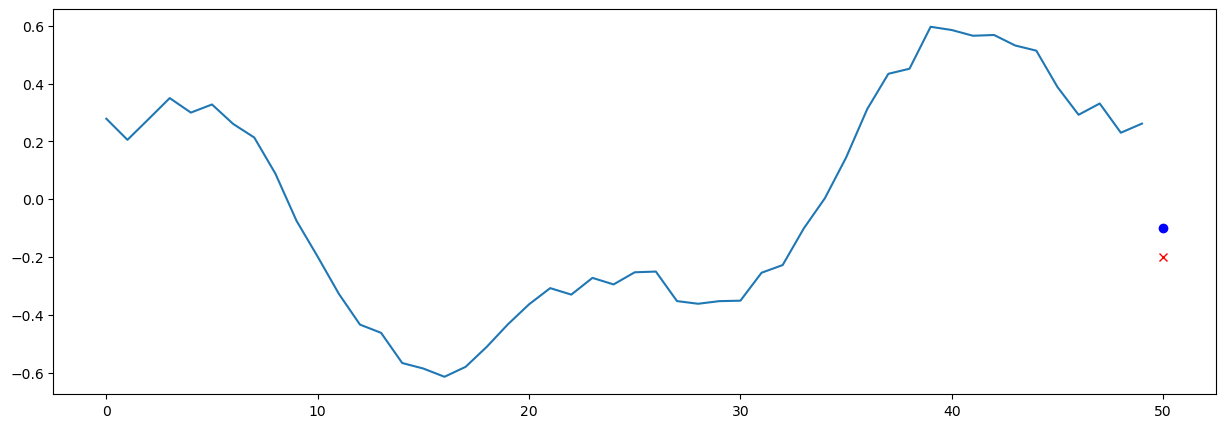

In [6]:
plot_serie(X_test[0], lg_sec, -0.1, -0.2)

Vamos a decirle que la "predicción" sea igual al punto

In [7]:
def modelo_predice_igual_ultimo(x):
  ret = []
  for e in x:
    ret.append(e[-1])
  return ret

Decimos que la y_pred sea el último valor de X_train

rms modelo_predice_igual_ultimo = 0.08301575481891632


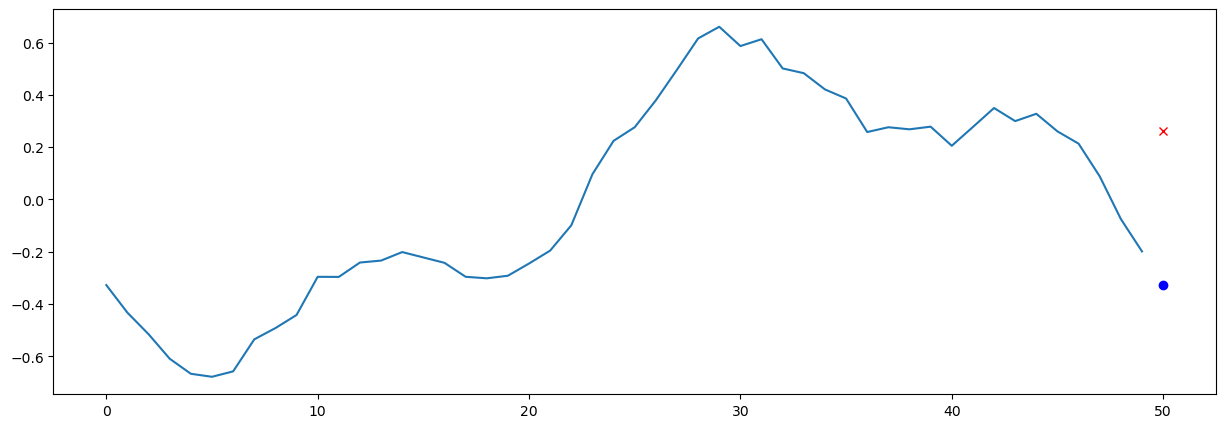

In [8]:
y_pred = modelo_predice_igual_ultimo(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_predice_igual_ultimo = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

# Modelo de Regresión Líneal Estadístico

In [9]:
def modelo_regresion_lineal(x):
    """Crea un modelo de regresión Lineal donde
    Sus X es cada uno de los valores de 0-len(e) en una lista y
    Sus Y es cada uno de los valores de 0-len(e) donde se recoge el index de ese for en e

    Args:
        x (int): Epochs

    Returns:
        int: Predicciones del modelo concatenadas
    """
    ret = []
    for e in x:
      regresor = LinearRegression()
      vx = [[i] for i in range(len(e))]
      vy = [[e[i]] for i in range(len(e))]
    
      regresor.fit(vx, vy)
      r1 = regresor.predict([[len(e)]])
      ret.append(r1)
    ret = np.concatenate(ret)
    return ret

rms modelo_regresion_lineal = 0.23966081491032293


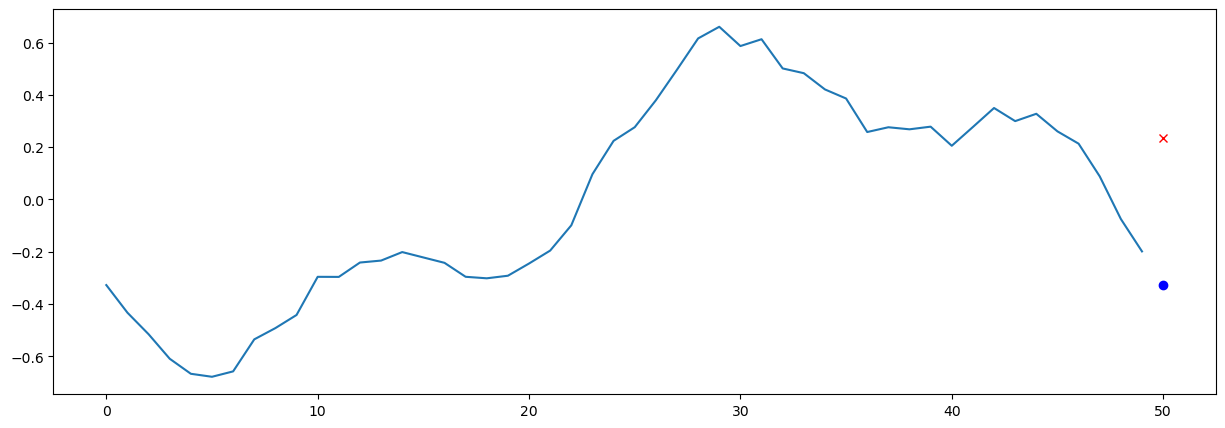

In [10]:
y_pred = modelo_regresion_lineal(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_regresion_lineal = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

# Red Densa

In [11]:
def modelo_red_densa(x_train, y_train):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(lg_sec)),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=100)
    return model



Epoch 1/100

2/2 [==============================] - 1s 6ms/step - loss: 0.2753
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1983
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1410
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 11/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 12/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 13/100
2/2 [==============================] - 0s 3ms

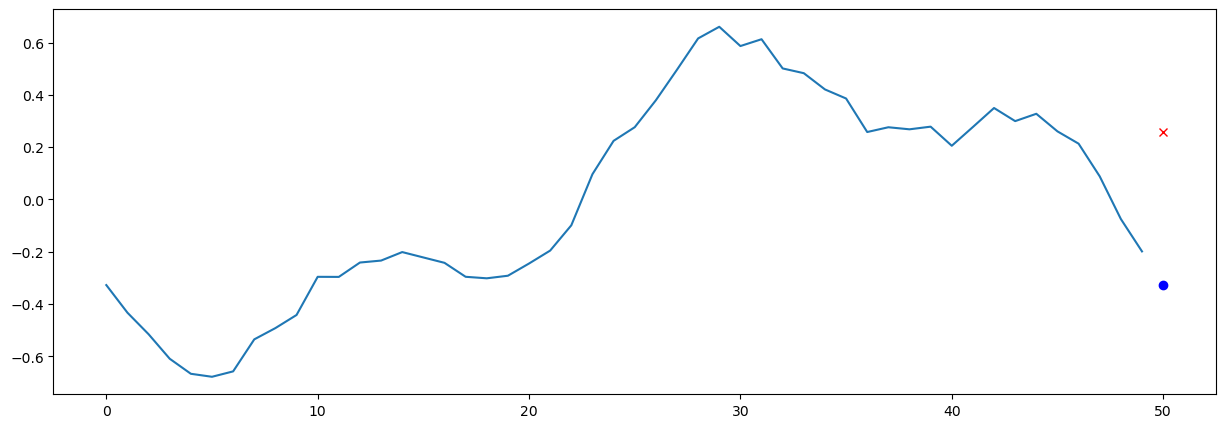

In [12]:
modelo = modelo_red_densa(X_train, y_train)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_densa = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

# Red Recurrente

## Red Recurrente de 1 Neurona

In [13]:
def modelo_red_recurrente_1(x_train, y_train):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(1, return_sequences=False, input_shape=[None, 1])
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=100)
    return model

Epoch 1/100
2/2 [==============================] - 1s 7ms/step - loss: 0.1820
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.1794
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1765
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1739
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1714
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1689
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1665
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1639
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.1618
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 0.1594
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1572
Epoch 12/100
2/2 [==============================] - 0s 5ms/step - loss: 0.1550
Epoch 13/100
2/2 [==============================] - 0s 2ms/st

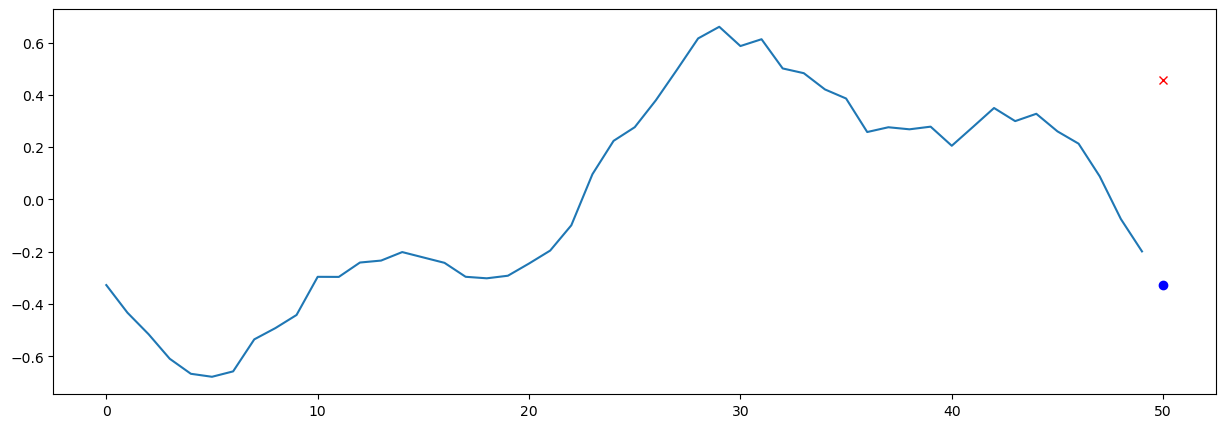

In [14]:
modelo = modelo_red_recurrente_1(X_train, y_train)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

In [15]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Modelo de varias neuronas

In [16]:
def modelo_red_recurrente_2(x_train, y_train,n_neuronas):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False, input_shape=[None, 1]),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=50)
    return model

Epoch 1/50
2/2 [==============================] - 1s 9ms/step - loss: 0.2374
Epoch 2/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0549
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0496
Epoch 4/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0548
Epoch 5/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0387
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0261
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 8/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 9/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 11/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 13/50
2/2 [==============================] - 0s 7ms/step - loss: 0.

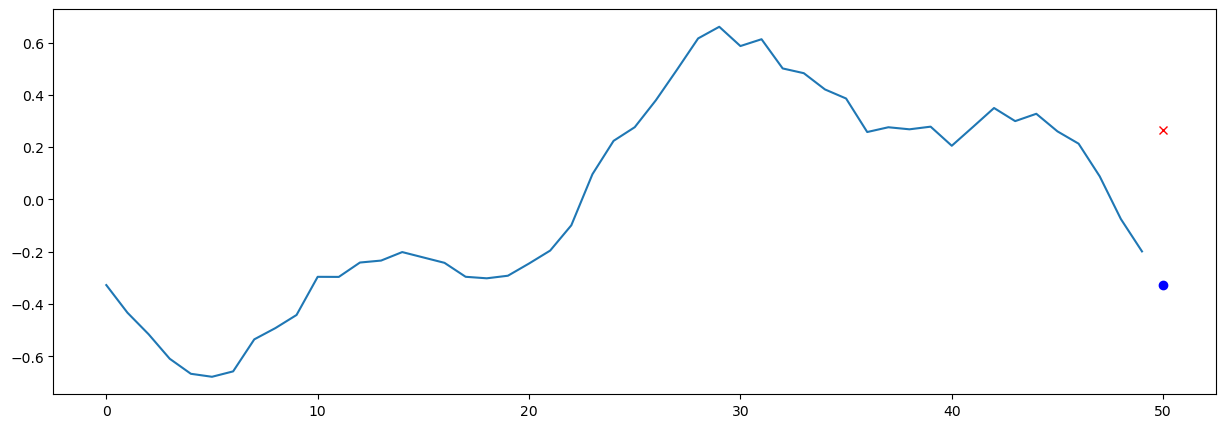

In [17]:
modelo = modelo_red_recurrente_2(X_train, y_train, 50)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

## De 3 Capas

In [18]:
"""OJO CON EL RETURN_SEQUENCES"""
def modelo_red_recurrente_3(x_train, y_train,n_neuronas):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False, input_shape=[None, 1]),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=50)
    return model

Epoch 1/50
2/2 [==============================] - 2s 13ms/step - loss: 0.2841
Epoch 2/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0336
Epoch 3/50
2/2 [==============================] - 0s 14ms/step - loss: 0.0586
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0212
Epoch 5/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0303
Epoch 6/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 7/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0096
Epoch 8/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0114
Epoch 9/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0131
Epoch 10/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0086
Epoch 11/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 12/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 13/50
2/2 [==============================] - 0s 12ms/st

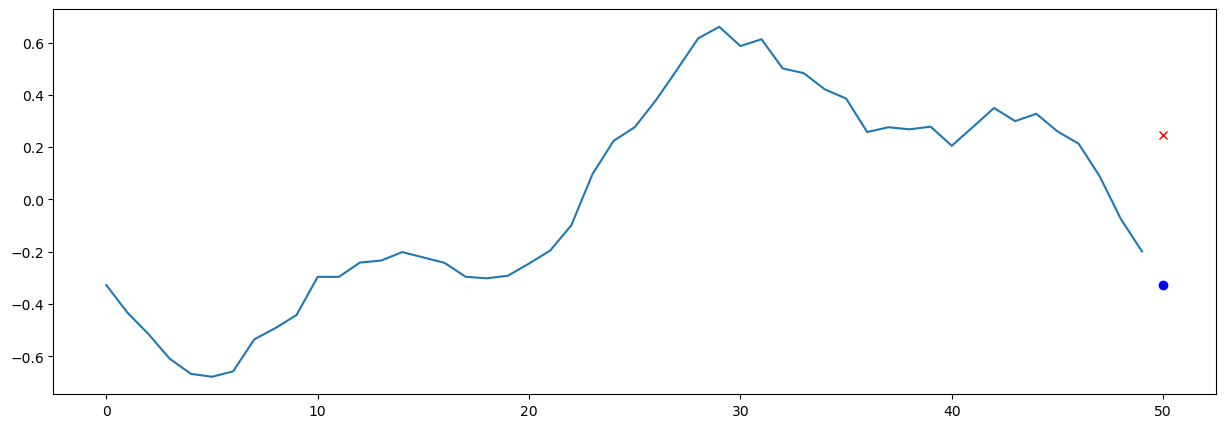

In [19]:
modelo = modelo_red_recurrente_3(X_train, y_train, 50)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

## Predicción Multi valor

In [20]:
lg_y = 10
rnn_predice_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(lg_y)
    ])
rnn_predice_10.compile(loss="mse", optimizer="adam")

In [21]:
lg_y = 10

x, y = genera_train(s1, lg_sec,  lg_y)
lim = int((len(x) * 0.8))
X_train, y_train = x[:lim], y[:lim]
X_test, y_test = x[lim:], y[lim:]


In [22]:
rnn_predice_10.fit(X_train, y_train,epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.5725
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.4027
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.2986
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2409
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2123
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.1958
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.1806
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.1636
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.1458
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 0.1299
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss: 0.1173
Epoch 12/100
1/1 [==============================] - 0s 13ms/step - loss: 0.1079
Epoch 13/100
1/1 [==============================] -

In [23]:
y_pred = rnn_predice_10.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms rnn_predice_10 = {rms}")

1/1 [==============================] - 0s 235ms/step
rms rnn_predice_10 = 0.06830345094203949


### Predecir 10 valores V2

In [24]:
# Por cada valor proporcionado, devuelve 10
lg_y = 10
lg_sec = 1
x, y = genera_train(s1, lg_sec,  lg_y)
lim = int((len(x) * 0.8))
X_train, y_train = x[:lim], y[:lim]
X_test, y_test = x[lim:], y[lim:]


"""EN ESTE SE VA BASAR EN SU PROPIO DATO PARA GENERAR EL SIGUIENTE PARA CONTINUAR"""
rnn_predice_1_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.Dense(lg_y)
    ])
rnn_predice_1_10.compile(loss="mse", optimizer="adam")
rnn_predice_1_10.fit(X_train, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 2s 4ms/step - loss: 0.1487
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1421
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1388
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1376
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1369
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1383
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1379
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1371
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1362
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1362
Epoch 11/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1359
Epoch 12/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1358
Epoch 13/100
3/3 [==============================] - 0s 3ms/st

In [25]:
y_pred = rnn_predice_10.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], -1)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms rnn_predice_10 = {rms}")

1/1 [==============================] - 0s 239ms/step
rms rnn_predice_10 = 0.38319510221481323
